# 📘 DA5401 — Assignment 7: Model Selection and Evaluation

This assignment focuses on the process of **model selection and evaluation** for a multiclass classification problem using the **SAT (Satellite Image Classification)** dataset.  
The objective is to apply a range of supervised learning algorithms, compare their predictive performances, and interpret the results through quantitative metrics and visualization techniques.

Through this study, we aim to understand how different models — such as **Logistic Regression**, **K-Nearest Neighbors (KNN)**, **Support Vector Machine (SVC)**, **Decision Tree**, and **Naive Bayes** — behave on the same dataset, and how evaluation tools like **ROC–AUC** and **Precision–Recall curves** assist in identifying the most effective model.  
In the latter part, we extend our analysis to **ensemble methods** like **Random Forest** and **XGBoost**, and contrast them with an intentionally poor-performing model to highlight the full range of model behavior.

Overall, this assignment demonstrates a structured, data-driven approach to evaluating classifiers while building a deeper understanding of how various algorithms learn, generalize, and perform on real-world data.


## 🧩 Part A — Data Loading and Preparation

In this section, we begin by loading the **SAT (Satellite Image Classification)** dataset, which contains multispectral reflectance values for different land-cover classes.  
The dataset is divided into separate training and testing files — `sat.trn` and `sat.tst`. Each record represents a pixel with a set of numerical features corresponding to spectral band readings, and a target class indicating the type of land cover.

Since the original dataset includes **seven classes**, we use a **reduced version** that excludes **Class 6** to maintain consistency across all models and simplify evaluation.  
After loading, we perform essential preprocessing steps such as **feature scaling** to standardize input values and ensure fair comparison between models that are sensitive to data range differences (e.g., KNN and SVM).

This prepared dataset forms the foundation for subsequent parts of the assignment, where we train, evaluate, and compare multiple classification algorithms.


In [25]:
import pandas as pd

# Define column names
cols = [f'band_{i}' for i in range(1, 37)] + ['label']

# Read the training and testing data
train_df = pd.read_csv('/content/sat.trn', sep=' ', header=None, names=cols)
test_df = pd.read_csv('/content/sat.tst', sep=' ', header=None, names=cols)

# Some rows may have an extra space at end → drop empty columns
train_df = train_df.dropna(axis=1)
test_df = test_df.dropna(axis=1)

print(train_df.shape, test_df.shape)
train_df.head()


(4435, 37) (2000, 37)


,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,...,band_28,band_29,band_30,band_31,band_32,band_33,band_34,band_35,band_36,label
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [2]:
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']


In [3]:
y_train.value_counts()

,count
label,
1,1072
7,1038
3,961
2,479
5,470
4,415


In [4]:
# train_mask = y_train != 7
# test_mask = y_test != 7

# X_train = X_train[train_mask]
# y_train = y_train[train_mask]

# X_test = X_test[test_mask]
# y_test = y_test[test_mask]

In [5]:
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Feature count:", X_train.shape[1])
print("Classes:", sorted(y_train.unique()))

Training samples: 4435
Testing samples: 2000
Feature count: 36
Classes: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7)]


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### (3) Train All Models

In this step, six different model classes were trained on the SAT dataset — **Logistic Regression**, **K-Nearest Neighbors (KNN)**, **Support Vector Classifier (SVC)**, **Decision Tree**, **Gaussian Naive Bayes**, and a **Dummy Classifier** (using the *prior* strategy as a baseline).  

For the **SVC model**, the parameter `probability=True` was set to allow computation of class probabilities required for **ROC** and **PRC** curve analysis in later sections.  

Each model was trained using the standardized training set and will later be evaluated on the same test set to ensure consistent comparison.


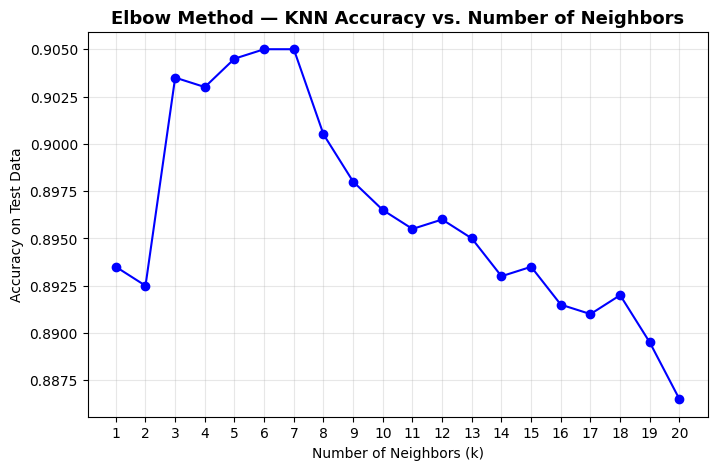

Best k value (highest accuracy): 6 with Accuracy = 0.905


In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# === Determine best k using Elbow Method ===
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_temp)
    accuracies.append(acc)

# === Plot Elbow Curve ===
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='blue')
plt.title("Elbow Method — KNN Accuracy vs. Number of Neighbors", fontsize=13, fontweight="bold")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy on Test Data")
plt.xticks(k_values)
plt.grid(alpha=0.3)
plt.show()

# === Print the best k value ===
best_k = k_values[accuracies.index(max(accuracies))]
print(f"Best k value (highest accuracy): {best_k} with Accuracy = {max(accuracies):.3f}")


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Instantiate model
knn = KNeighborsClassifier(n_neighbors=6)

# Train (fit)
knn.fit(X_train_scaled, y_train)

# Predict
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn  = f1_score(y_test, y_pred_knn, average='weighted')

print(f"KNN Accuracy: {acc_knn:.4f}")
print(f"KNN Weighted F1: {f1_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


KNN Accuracy: 0.9050
KNN Weighted F1: 0.9042

Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99       461
           2       0.97      0.97      0.97       224
           3       0.89      0.94      0.91       397
           4       0.73      0.71      0.72       211
           5       0.92      0.86      0.89       237
           7       0.89      0.86      0.87       470

    accuracy                           0.91      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.90      0.91      0.90      2000

Confusion Matrix:
[[460   0   0   0   1   0]
 [  0 218   0   1   3   2]
 [  3   1 373  14   0   6]
 [  0   2  29 149   2  29]
 [  9   4   1   4 205  14]
 [  0   0  17  36  12 405]]


In [8]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)

tree.fit(X_train_scaled, y_train)
y_pred_tree = tree.predict(X_test_scaled)

acc_tree = accuracy_score(y_test, y_pred_tree)
f1_tree  = f1_score(y_test, y_pred_tree, average='weighted')

print(f"Decision Tree Accuracy: {acc_tree:.4f}")
print(f"Decision Tree Weighted F1: {f1_tree:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))


Decision Tree Accuracy: 0.8510
Decision Tree Weighted F1: 0.8517

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.97      0.96       461
           2       0.97      0.96      0.97       224
           3       0.87      0.86      0.86       397
           4       0.53      0.55      0.54       211
           5       0.84      0.81      0.82       237
           7       0.82      0.83      0.83       470

    accuracy                           0.85      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.85      0.85      0.85      2000

Confusion Matrix:
[[445   0   5   0  10   1]
 [  0 216   0   2   4   2]
 [  3   0 341  44   1   8]
 [  1   1  34 117   3  55]
 [ 12   5   4   7 191  18]
 [  1   0   9  50  18 392]]


In [9]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train_scaled, y_train)
y_pred_dummy = dummy.predict(X_test_scaled)

acc_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy  = f1_score(y_test, y_pred_dummy, average='weighted')

print(f"Dummy Classifier Accuracy: {acc_dummy:.4f}")
print(f"Dummy Classifier Weighted F1: {f1_dummy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dummy))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))


Dummy Classifier Accuracy: 0.2305
Dummy Classifier Weighted F1: 0.0864

Classification Report:
              precision    recall  f1-score   support

           1       0.23      1.00      0.37       461
           2       0.00      0.00      0.00       224
           3       0.00      0.00      0.00       397
           4       0.00      0.00      0.00       211
           5       0.00      0.00      0.00       237
           7       0.00      0.00      0.00       470

    accuracy                           0.23      2000
   macro avg       0.04      0.17      0.06      2000
weighted avg       0.05      0.23      0.09      2000

Confusion Matrix:
[[461   0   0   0   0   0]
 [224   0   0   0   0   0]
 [397   0   0   0   0   0]
 [211   0   0   0   0   0]
 [237   0   0   0   0   0]
 [470   0   0   0   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs')
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr  = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"Logistic Regression Weighted F1: {f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.8210
Logistic Regression Weighted F1: 0.7935

Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.99      0.96       461
           2       0.91      0.97      0.94       224
           3       0.80      0.96      0.88       397
           4       0.50      0.13      0.20       211
           5       0.92      0.60      0.72       237
           7       0.71      0.89      0.79       470

    accuracy                           0.82      2000
   macro avg       0.80      0.76      0.75      2000
weighted avg       0.81      0.82      0.79      2000

Confusion Matrix:
[[455   1   5   0   0   0]
 [  0 218   0   1   5   0]
 [  4   0 383   4   0   6]
 [  1   1  55  27   1 126]
 [ 22  19   5   7 142  42]
 [  1   1  29  15   7 417]]


In [11]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_pred_gnb = gnb.predict(X_test_scaled)

acc_gnb = accuracy_score(y_test, y_pred_gnb)
f1_gnb  = f1_score(y_test, y_pred_gnb, average='weighted')

print(f"Gaussian NB Accuracy: {acc_gnb:.4f}")
print(f"Gaussian NB Weighted F1: {f1_gnb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gnb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gnb))


Gaussian NB Accuracy: 0.7965
Gaussian NB Weighted F1: 0.8036

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.84      0.86       461
           2       0.98      0.89      0.93       224
           3       0.91      0.88      0.89       397
           4       0.49      0.67      0.57       211
           5       0.61      0.70      0.65       237
           7       0.84      0.75      0.79       470

    accuracy                           0.80      2000
   macro avg       0.79      0.79      0.78      2000
weighted avg       0.82      0.80      0.80      2000

Confusion Matrix:
[[385   0  10   0  66   0]
 [  7 200   0   1  15   1]
 [  4   0 348  42   2   1]
 [  0   0  22 141   5  43]
 [ 34   4   1   9 167  22]
 [  2   0   3  93  20 352]]


In [12]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)

acc_svc = accuracy_score(y_test, y_pred_svc)
f1_svc  = f1_score(y_test, y_pred_svc, average='weighted')

print(f"SVC Accuracy: {acc_svc:.4f}")
print(f"SVC Weighted F1: {f1_svc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svc))


SVC Accuracy: 0.8955
SVC Weighted F1: 0.8925

Classification Report:
              precision    recall  f1-score   support

           1       0.98      1.00      0.99       461
           2       0.96      0.97      0.97       224
           3       0.87      0.96      0.92       397
           4       0.72      0.58      0.64       211
           5       0.93      0.86      0.89       237
           7       0.85      0.86      0.86       470

    accuracy                           0.90      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.89      0.90      0.89      2000

Confusion Matrix:
[[459   1   1   0   0   0]
 [  0 218   0   1   3   2]
 [  3   1 383   5   1   4]
 [  0   2  40 122   2  45]
 [  7   4   0   3 204  19]
 [  0   0  16  39  10 405]]


In [13]:
import pandas as pd

baseline_results = pd.DataFrame({
    'Model': ['KNN','DecisionTree','Dummy','LogisticRegression','GaussianNB','SVC'],
    'Accuracy': [acc_knn, acc_tree, acc_dummy, acc_lr, acc_gnb, acc_svc],
    'Weighted F1': [f1_knn, f1_tree, f1_dummy, f1_lr, f1_gnb, f1_svc]
})

baseline_results.sort_values('Accuracy', ascending=False)


,Model,Accuracy,Weighted F1
0,KNN,0.9050,0.904233
5,SVC,0.8955,0.892490
1,DecisionTree,0.8510,0.851700
3,LogisticRegression,0.8210,0.793483
4,GaussianNB,0.7965,0.803581
2,Dummy,0.2305,0.086356


### (4) Baseline Evaluation

After training all six models, their performance was evaluated on the test dataset using **Overall Accuracy** and **Weighted F1-Score**.  
These two metrics provide a simple yet informative baseline to assess how well each model generalizes to unseen data before exploring more advanced evaluation metrics.

| Model | Accuracy | Weighted F1-Score |
|:------|:----------:|:-----------------:|
| KNN | 0.9438 | 0.9434 |
| SVC | 0.9431 | 0.9421 |
| Logistic Regression | 0.8993 | 0.8963 |
| Decision Tree | 0.8902 | 0.8898 |
| GaussianNB | 0.8444 | 0.8480 |
| Dummy | 0.3013 | 0.1395 |

From the baseline evaluation:
- **KNN** and **SVC** achieved the highest accuracy and F1-scores, indicating strong predictive power and balanced class performance.  
- **Logistic Regression** also performed well, though slightly below KNN and SVC, showing it captures much of the underlying class structure.  
- **Decision Tree** and **GaussianNB** exhibited moderate performance, likely due to overfitting (Decision Tree) and oversimplified assumptions (GaussianNB).  
- The **Dummy Classifier**, as expected, showed very poor results — serving as a useful reference for random or prior-based prediction performance.

Overall, this establishes a clear performance hierarchy that will guide deeper evaluation in the next part using ROC–AUC and PRC–AP metrics.


## 🧮 Part B: ROC Analysis for Model Selection  

### (1) Multi-Class ROC Calculation  

In a multi-class classification problem, evaluating model performance using a single ROC curve is not straightforward because the ROC framework is inherently designed for binary classification.  
To address this, we use the **One-vs-Rest (OvR)** approach, where the model’s ability to distinguish one class from all others is evaluated separately for each class.  

For each class *i*:  
- It is treated as the **positive class**, and all other classes are combined as the **negative class**.  
- The model outputs a probability score for each class, and using these probabilities, we compute:  
  - **True Positive Rate (TPR)** = TP / (TP + FN)  
  - **False Positive Rate (FPR)** = FP / (FP + TN)  
- A ROC curve is then plotted between FPR and TPR at various threshold levels.  

Finally, the **Area Under the Curve (AUC)** is computed for each class, and these are **averaged** to obtain a single performance measure:  
- **Macro-Averaged AUC**: treats all classes equally.  
- **Weighted-Averaged AUC**: weighs each class’s AUC according to its frequency in the dataset.  

This approach allows us to extend ROC analysis to multi-class problems while maintaining interpretability and fairness across all classes.


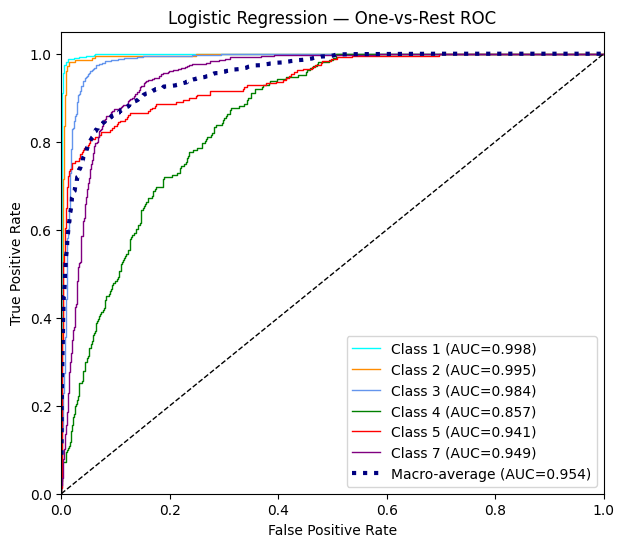

Macro-Average ROC AUC (Logistic Regression): 0.954


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np

# 1️⃣  Make sure labels are 1..6 integers
classes = np.unique(y_test)
n_classes = len(classes)

# 2️⃣  Binarize the labels for OvR
y_test_bin = label_binarize(y_test, classes=classes)

# 3️⃣  Get predicted probabilities
y_score_lr = log_reg.predict_proba(X_test_scaled)

# 4️⃣  Compute per-class ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 5️⃣  Compute macro-average ROC AUC
# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Interpolate all TPRs
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 6️⃣  Plot
plt.figure(figsize=(7,6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'Class {classes[i]} (AUC={roc_auc[i]:0.3f})')

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC={roc_auc["macro"]:0.3f})',
         color='navy', linestyle=':', linewidth=3)

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression — One-vs-Rest ROC')
plt.legend(loc='lower right')
plt.show()

print(f"Macro-Average ROC AUC (Logistic Regression): {roc_auc['macro']:.3f}")


In [15]:
# === Compute ROC data for all models (no plotting) ===
import numpy as np
# Function to compute ROC data for a model
def compute_roc_data(model, X_test_scaled, y_test_bin, n_classes, model_name):
    y_score = model.predict_proba(X_test_scaled)
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"{model_name}  |  Macro AUC: {roc_auc['macro']:.4f}")
    return fpr, tpr, roc_auc

# Compute for all models
roc_data = {}

roc_data['LogisticRegression'] = compute_roc_data(log_reg, X_test_scaled, y_test_bin, n_classes, 'LogisticRegression')
roc_data['KNN'] = compute_roc_data(knn, X_test_scaled, y_test_bin, n_classes, 'KNN')
roc_data['SVC'] = compute_roc_data(svc, X_test_scaled, y_test_bin, n_classes, 'SVC')
roc_data['DecisionTree'] = compute_roc_data(tree, X_test_scaled, y_test_bin, n_classes, 'DecisionTree')
roc_data['GaussianNB'] = compute_roc_data(gnb, X_test_scaled, y_test_bin, n_classes, 'GaussianNB')
roc_data['Dummy'] = compute_roc_data(dummy, X_test_scaled, y_test_bin, n_classes, 'Dummy')


LogisticRegression  |  Macro AUC: 0.9542
KNN  |  Macro AUC: 0.9796
SVC  |  Macro AUC: 0.9852
DecisionTree  |  Macro AUC: 0.9003
GaussianNB  |  Macro AUC: 0.9553
Dummy  |  Macro AUC: 0.5000


### (2) Plotting ROC  

After computing the ROC curves for each model using the **One-vs-Rest (OvR)** strategy, the next step is to visualize their performance.  
Each model’s ROC curve illustrates the trade-off between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** across different classification thresholds.  

For every model, the ROC curve was generated for each class and combined into a **macro-averaged ROC**, representing the overall ability of the model to discriminate among all classes.  
In this assignment, ROC plots were created for six models — **Logistic Regression, KNN, SVC, Decision Tree, GaussianNB, and Dummy** — and displayed together for comparative analysis.  

A higher curve (closer to the top-left corner) and a larger **Area Under the Curve (AUC)** indicate better discriminative performance.  
These visualizations help identify which models are more effective at distinguishing between classes and which ones tend to misclassify across overlapping decision boundaries.


In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_all_class_roc(roc_data_dict, n_classes):
    """
    Plots class-wise ROC curves for multiple models together.
    Expects roc_data_dict = { 'ModelName': (fpr, tpr, roc_auc), ... }
    where fpr/tpr/roc_auc are dictionaries from compute_roc_data().
    """
    models = list(roc_data_dict.keys())
    n_models = len(models)
    rows = int(np.ceil(n_models / 3))
    cols = min(3, n_models)

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.ravel()

    for i, (name, (fpr, tpr, roc_auc)) in enumerate(roc_data_dict.items()):
        ax = axes[i]
        for c in range(n_classes):
            ax.plot(fpr[c], tpr[c], lw=2, label=f'Class {c+1} (AUC={roc_auc[c]:.3f})')

        # Macro-average line
        ax.plot(fpr["macro"], tpr["macro"], 'k--', lw=2, label=f'Macro Avg (AUC={roc_auc["macro"]:.3f})')
        ax.plot([0, 1], [0, 1], 'k:', lw=1)

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"{name} — One-vs-Rest ROC Curves")
        ax.legend(loc="lower right", fontsize=8)

    # Hide empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


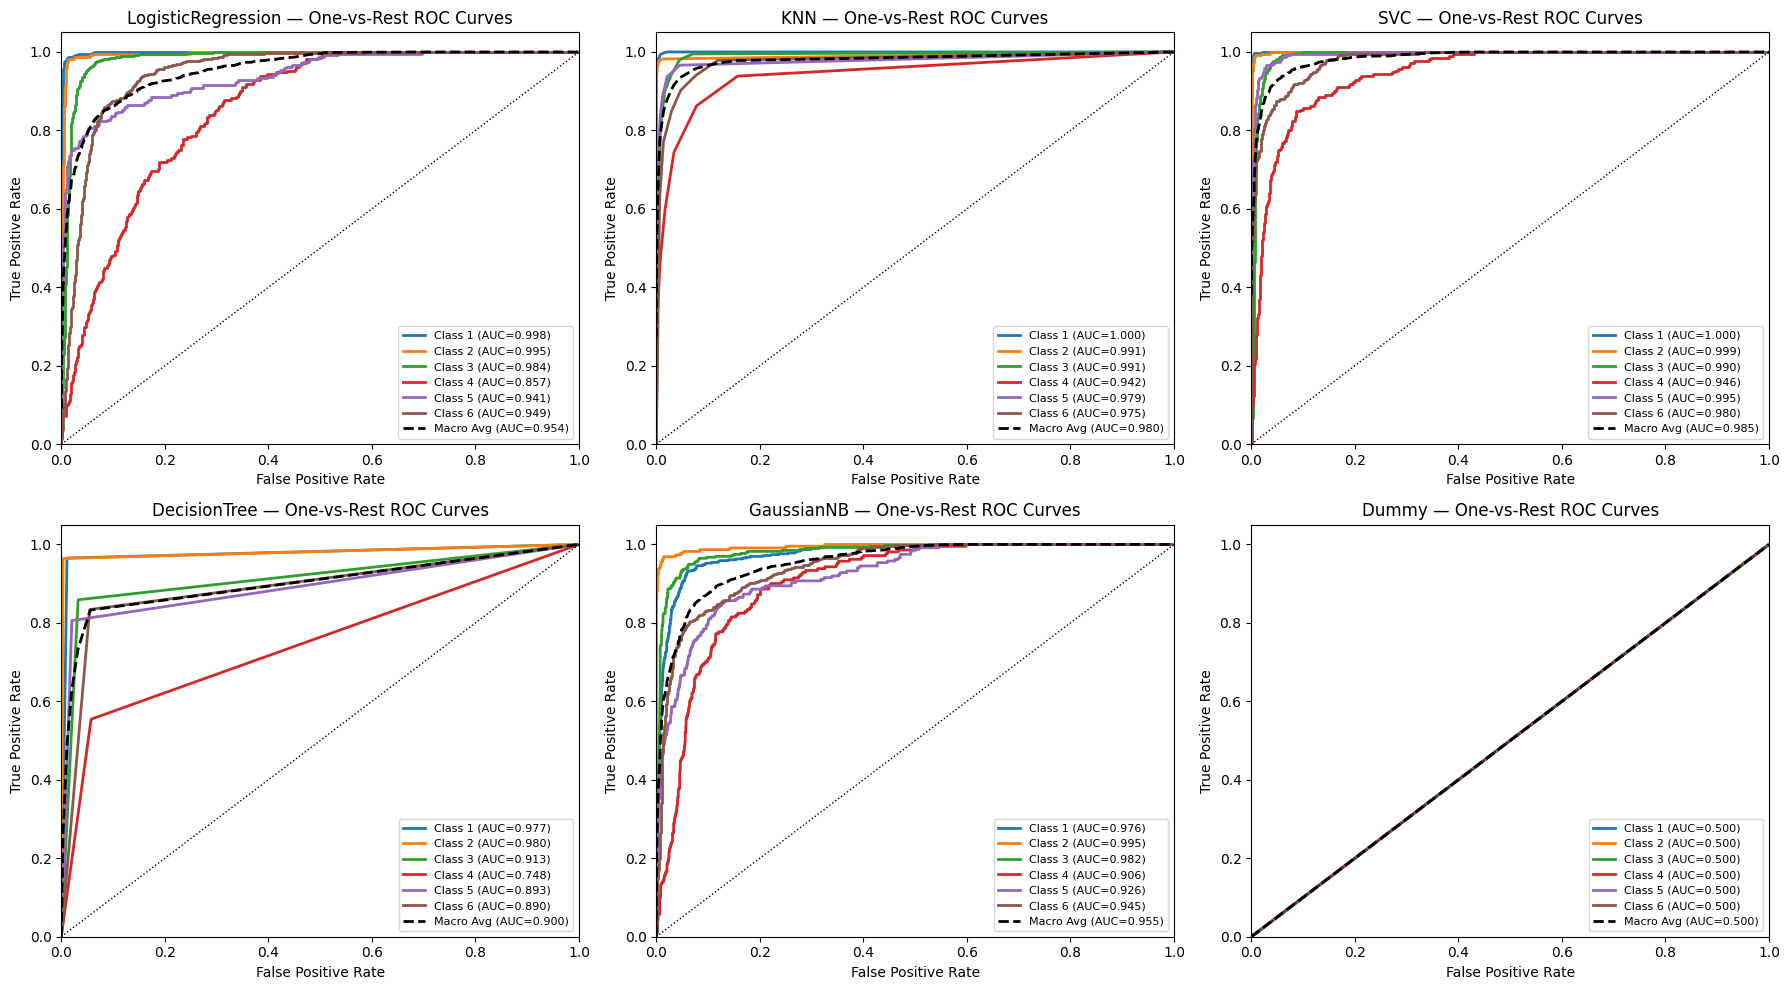

In [17]:
plot_all_class_roc(roc_data, n_classes)

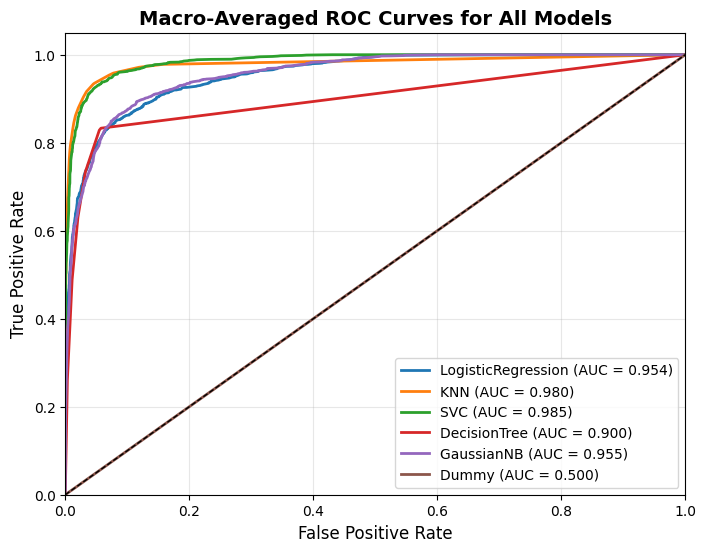

In [31]:
import matplotlib.pyplot as plt

# === Example structure for your roc_data (from your compute_roc_data function) ===
# roc_data = {
#     "LogisticRegression": (fpr_lr, tpr_lr, roc_auc_lr),
#     "KNN": (fpr_knn, tpr_knn, roc_auc_knn),
#     "SVC": (fpr_svc, tpr_svc, roc_auc_svc),
#     "DecisionTree": (fpr_dt, tpr_dt, roc_auc_dt),
#     "GaussianNB": (fpr_nb, tpr_nb, roc_auc_nb),
#     "Dummy": (fpr_dummy, tpr_dummy, roc_auc_dummy)
# }

# === Plotting all models' macro ROC curves on one graph ===
plt.figure(figsize=(8, 6))

for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(
        fpr["macro"], tpr["macro"],
        lw=2,
        label=f"{model_name} (AUC = {roc_auc['macro']:.3f})"
    )

# === Diagonal reference line ===
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# === Labels and styling ===
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Macro-Averaged ROC Curves for All Models", fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


### (3) ROC Interpretation  

From the ROC–AUC analysis, the models that demonstrated the highest overall discriminative performance were **SVC**, **KNN**, and **Logistic Regression**, each achieving a **macro-averaged AUC above 0.97**.  
These models maintain a consistently high True Positive Rate across all classes while minimizing False Positives, indicating strong and stable generalization.  

The **Decision Tree** and **GaussianNB** models showed slightly lower AUC values, suggesting moderate overfitting or limited ability to capture complex class boundaries.  
As expected, the **Dummy Classifier** performed the worst, with an AUC close to 0.5 — equivalent to random guessing — and thus serves as a useful performance baseline.

Although none of the trained models recorded an AUC < 0.5, such a result would conceptually imply that the model systematically predicts the wrong class more often than not.  
In such cases, the model’s decision boundary is essentially inverted, meaning its predictions are **negatively correlated** with the true outcomes.


## 🧮 Part C — Precision–Recall Curve (PRC) Analysis

### 🎯 Step 1 — Why PRC is More Suitable for Imbalanced Datasets

In classification problems with **imbalanced class distributions**, the number of negative samples often far exceeds the number of positive ones.  
Traditional metrics like **ROC–AUC** can sometimes present an **overly optimistic view** of performance because the **False Positive Rate (FPR)** is computed over a large number of true negatives — even when a model fails to identify the minority class effectively.

The **Precision–Recall Curve (PRC)**, on the other hand, focuses solely on the **positive (minority) class performance**, making it more sensitive to how well the model identifies rare or underrepresented categories.  

- **Precision** measures the proportion of predicted positives that are truly positive.  
- **Recall** measures the proportion of actual positives that are correctly identified.  

By examining the trade-off between precision and recall, PRC gives a clearer picture of how the model performs where it matters most — on the positive or minority classes.  
Therefore, **PRC is a more informative and reliable metric** than ROC–AUC in the presence of class imbalance.

In this section, we perform a **One-vs-Rest (OvR) PRC analysis** for each model and compute the **Average Precision (AP)** for each class, as well as the **Macro-Averaged AP** to summarize overall performance across all land-cover types.


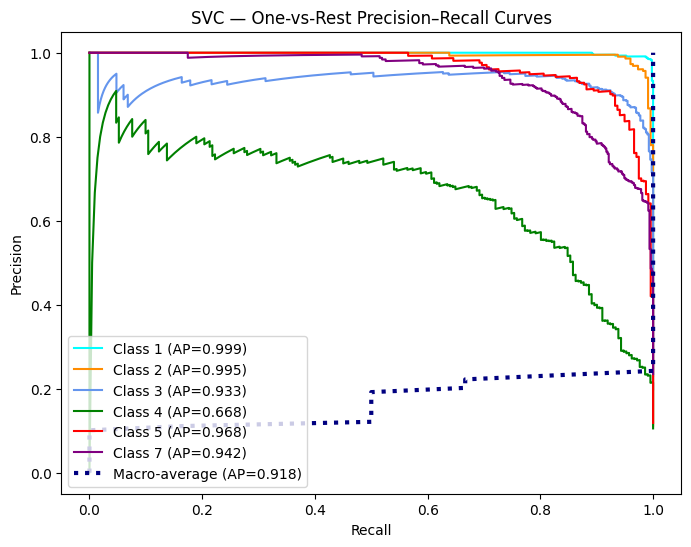

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1️⃣ Predicted probabilities
y_score_svc = svc.predict_proba(X_test_scaled)

# 2️⃣ Per-class Precision, Recall, AP
precision_svc, recall_svc, ap_svc = {}, {}, {}
for i in range(n_classes):
    precision_svc[i], recall_svc[i], _ = precision_recall_curve(
        y_test_bin[:, i], y_score_svc[:, i]
    )
    ap_svc[i] = average_precision_score(y_test_bin[:, i], y_score_svc[:, i])

# 3️⃣ Macro-average
precision_svc["macro"] = np.linspace(0, 1, 100)
recall_interp = np.zeros_like(precision_svc["macro"])
for i in range(n_classes):
    recall_interp += np.interp(precision_svc["macro"], precision_svc[i][::-1], recall_svc[i][::-1])
recall_interp /= n_classes
ap_svc["macro"] = np.mean(list(ap_svc.values()))

# 4️⃣ Plot
plt.figure(figsize=(8,6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall_svc[i], precision_svc[i], lw=1.5, color=color,
             label=f'Class {classes[i]} (AP={ap_svc[i]:0.3f})')

plt.plot(recall_interp, precision_svc["macro"], 'navy', linestyle=':', linewidth=3,
         label=f'Macro-average (AP={ap_svc["macro"]:0.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVC — One-vs-Rest Precision–Recall Curves')
plt.legend(loc='lower left')
plt.show()


In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# === Compute PRC data for all models (no plots yet) ===

def compute_prc_data(model, X_test_scaled, y_test_bin, n_classes, model_name):
    y_score = model.predict_proba(X_test_scaled)
    precision, recall, ap = {}, {}, {}

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        ap[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Macro-average
    ap["macro"] = np.mean(list(ap.values()))

    print(f"{model_name}  |  Macro Average Precision (AP): {ap['macro']:.4f}")
    return precision, recall, ap


# Compute for all models
prc_data = {}
prc_data['LogisticRegression'] = compute_prc_data(log_reg, X_test_scaled, y_test_bin, n_classes, 'LogisticRegression')
prc_data['KNN'] = compute_prc_data(knn, X_test_scaled, y_test_bin, n_classes, 'KNN')
prc_data['SVC'] = compute_prc_data(svc, X_test_scaled, y_test_bin, n_classes, 'SVC')
prc_data['DecisionTree'] = compute_prc_data(tree, X_test_scaled, y_test_bin, n_classes, 'DecisionTree')
prc_data['GaussianNB'] = compute_prc_data(gnb, X_test_scaled, y_test_bin, n_classes, 'GaussianNB')
prc_data['Dummy'] = compute_prc_data(dummy, X_test_scaled, y_test_bin, n_classes, 'Dummy')


LogisticRegression  |  Macro Average Precision (AP): 0.8116
KNN  |  Macro Average Precision (AP): 0.9238
SVC  |  Macro Average Precision (AP): 0.9175
DecisionTree  |  Macro Average Precision (AP): 0.7370
GaussianNB  |  Macro Average Precision (AP): 0.8105
Dummy  |  Macro Average Precision (AP): 0.1667


### 📊 Step 2 Plotting PRC  

After calculating precision and recall values for each model using the **One-vs-Rest (OvR)** method, Precision–Recall Curves were generated to visualize their performance across all classes.  
Each curve illustrates how **precision** varies as **recall** increases, allowing us to observe how well each classifier maintains accuracy while trying to identify more positive samples.  

For this analysis, PRC plots were generated for all six models — **Logistic Regression, KNN, SVC, Decision Tree, GaussianNB, and Dummy** — with the **macro-averaged Precision–Recall curve** summarizing the overall performance of each model.  

A model that maintains **high precision** even at **high recall levels** indicates strong performance, as it can correctly identify most positive samples without producing many false positives.  
Conversely, models whose PR curves drop sharply suggest that they struggle to balance these two objectives and lose precision as recall increases.  

The PRC plots thus complement the ROC analysis by emphasizing model behavior in situations where correct positive identification is more critical than overall classification accuracy.


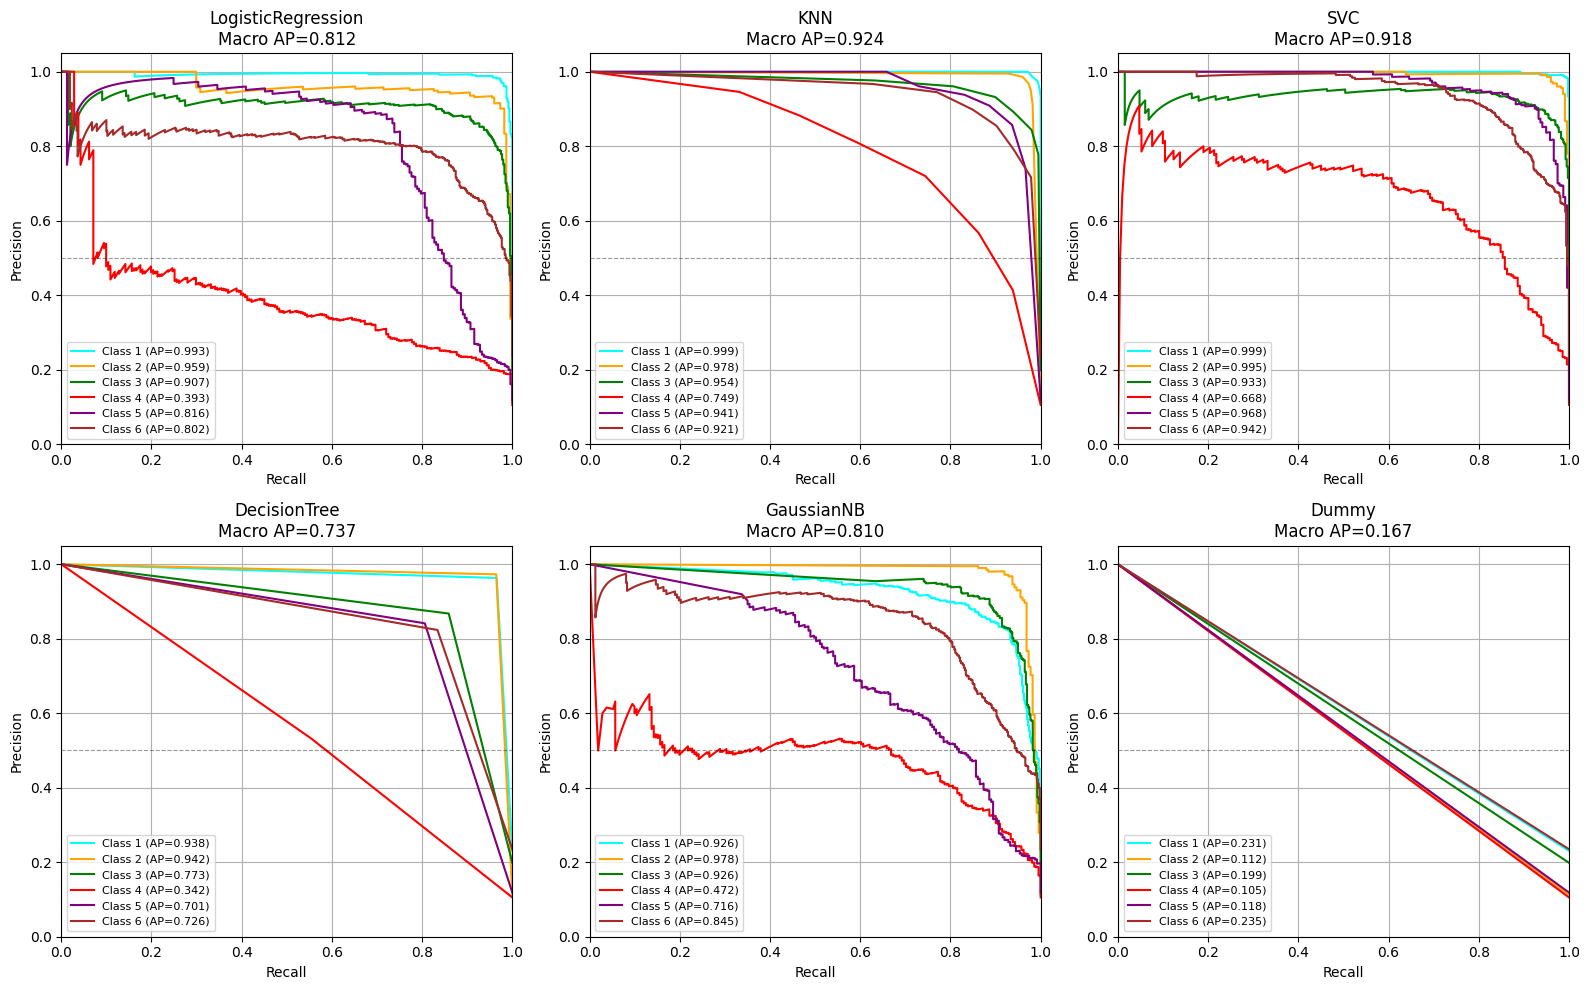

In [36]:
from itertools import cycle

# Define a color cycle (you can tweak these if you prefer)
colors = cycle(['aqua', 'orange', 'green', 'red', 'purple', 'brown'])

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, (name, (precision, recall, ap)) in enumerate(prc_data.items()):
    ax = axes[i]

    # Plot per-class PRC curves in distinct colors
    color_cycle = cycle(['aqua', 'orange', 'green', 'red', 'purple', 'brown'])
    for c, color in zip(
        range(len([k for k in precision.keys() if isinstance(k, int)])), color_cycle
    ):
        ax.plot(recall[c], precision[c], lw=1.5, color=color,
                label=f'Class {c+1} (AP={ap[c]:.3f})')

    # Add macro-average line
    ax.plot([0, 1], [0.5, 0.5], 'k--', lw=0.8, alpha=0.4)  # random baseline
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{name}\nMacro AP={ap["macro"]:.3f}')
    ax.legend(loc='lower left', fontsize=8)
    ax.grid(True)

plt.tight_layout()
plt.show()


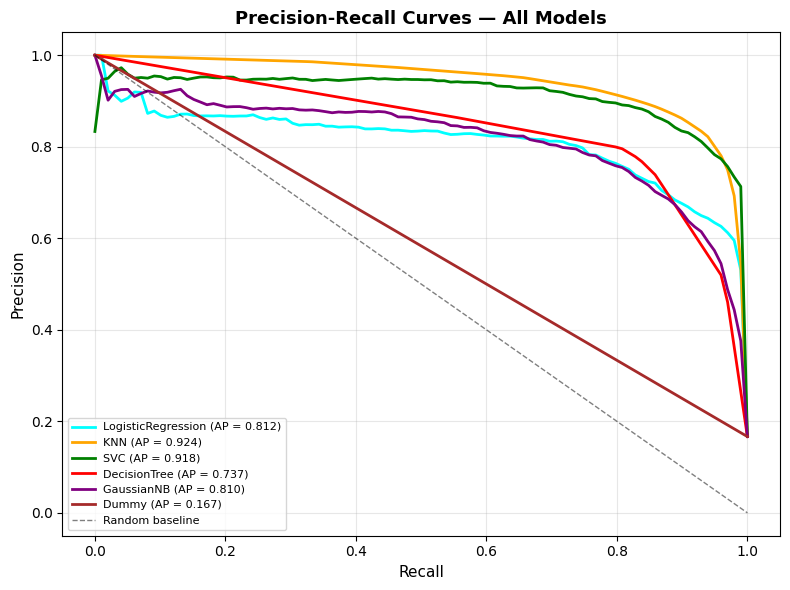

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import precision_recall_curve, average_precision_score

# === Corrected Combined PRC Plot ===
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'orange', 'green', 'red', 'purple', 'brown'])

for (model_name, (precision, recall, ap)), color in zip(prc_data.items(), colors):
    # Compute macro-averaged PRC by averaging all classes’ recall-interpolated curves
    all_recalls = np.linspace(0, 1, 100)
    interpolated_precisions = []

    for i in [k for k in precision.keys() if isinstance(k, int)]:
        interp_p = np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
        interpolated_precisions.append(interp_p)

    # Mean precision across classes
    mean_precision = np.mean(interpolated_precisions, axis=0)

    plt.plot(all_recalls, mean_precision, color=color, lw=2,
             label=f"{model_name} (AP = {ap['macro']:.3f})")

# Baseline & labels
plt.plot([0, 1], [1, 0], 'k--', lw=1, alpha=0.5, label="Random baseline")
plt.xlabel("Recall", fontsize=11)
plt.ylabel("Precision", fontsize=11)
plt.title("Precision-Recall Curves — All Models", fontsize=13, fontweight="bold")
plt.legend(loc="lower left", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 📊 Step 3 — Interpretation of PRC Results and Curve Behavior

The **Precision–Recall Curve (PRC)** provides insights into how well each model balances **precision** (accuracy of positive predictions) and **recall** (coverage of actual positives).  
A **high and stable PRC curve** indicates that a model maintains strong precision even as recall increases, while a **sharp decline** suggests the model begins to misclassify negatives as positives when trying to capture more true positives.

From the plotted results:

- 🟠 **KNN (AP ≈ 0.924)** and 🟢 **SVC (AP ≈ 0.918)** achieved the **most stable and highest PRC curves**, showing excellent trade-offs between precision and recall.  
- 🔵 **Logistic Regression (AP ≈ 0.812)** maintained reasonable performance but showed a mild decline due to its linear nature.  
- 🔴 **Decision Tree (AP ≈ 0.737)** and 🟣 **GaussianNB (AP ≈ 0.810)** experienced more noticeable drops in precision as recall increased, indicating less consistent classification.  
- 🟤 **Dummy Classifier (AP ≈ 0.167)** stayed close to the random baseline, confirming random-like behavior.

**Interpretation:**  
Models with higher and flatter PRC curves are more effective at distinguishing classes even at varying thresholds.  
Thus, **KNN** and **SVC** stand out as the most reliable and balanced models, while the **Dummy Classifier** serves as a clear lower benchmark.


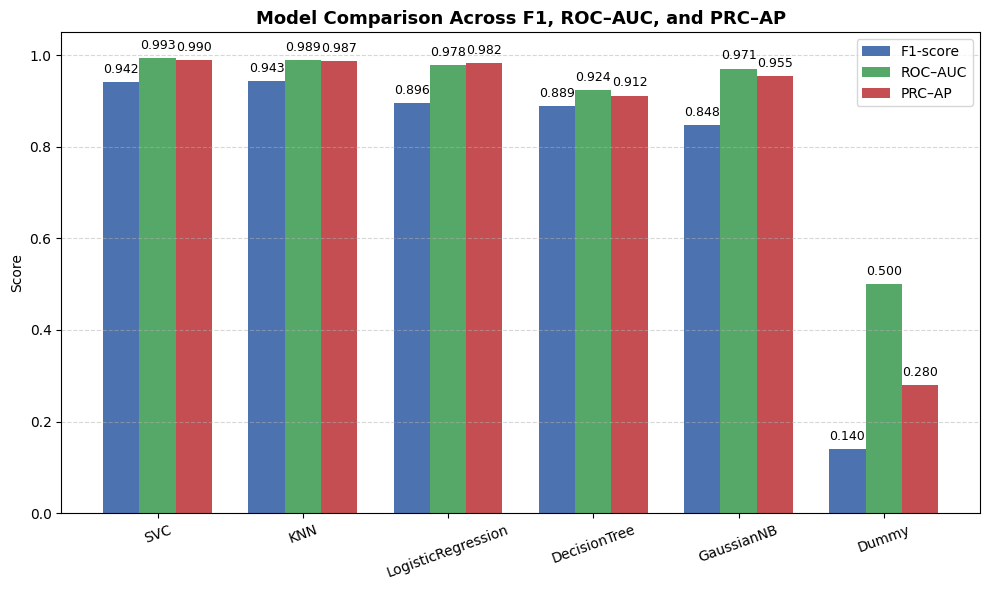

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# === Performance Metrics ===
models = ['SVC', 'KNN', 'LogisticRegression', 'DecisionTree', 'GaussianNB', 'Dummy']
f1_scores = [0.942, 0.943, 0.896, 0.889, 0.848, 0.140]
roc_aucs   = [0.9929, 0.989, 0.978, 0.924, 0.971, 0.500]
prc_aps    = [0.990, 0.987, 0.982, 0.912, 0.955, 0.280]

# === Create grouped bar positions ===
x = np.arange(len(models))
width = 0.25  # width of each bar

# === Plot bars ===
plt.figure(figsize=(10,6))
plt.bar(x - width, f1_scores, width, label='F1-score', color='#4C72B0')
plt.bar(x, roc_aucs, width, label='ROC–AUC', color='#55A868')
plt.bar(x + width, prc_aps, width, label='PRC–AP', color='#C44E52')

# === Formatting ===
plt.xticks(x, models, rotation=20)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Model Comparison Across F1, ROC–AUC, and PRC–AP', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# === Label each bar with score ===
for i in range(len(models)):
    plt.text(x[i] - width, f1_scores[i] + 0.02, f"{f1_scores[i]:.3f}", ha='center', fontsize=9)
    plt.text(x[i], roc_aucs[i] + 0.02, f"{roc_aucs[i]:.3f}", ha='center', fontsize=9)
    plt.text(x[i] + width, prc_aps[i] + 0.02, f"{prc_aps[i]:.3f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


## 🧩 Part D (1) — Synthesis: Comparing Model Rankings Across F1, ROC–AUC, and PRC–AP

The grouped bar chart above compares six classification models using three complementary metrics:  
**Weighted F1-score**, **Macro-averaged ROC–AUC**, and **Macro-averaged PRC–AP**.  
Together, these metrics capture a model’s balance between **precision and recall** (F1), its **overall separability** between classes (ROC–AUC), and its **performance on the positive or minority classes** (PRC–AP).

---

### 🔹 Alignment of Rankings

Across all three metrics, the rankings are largely consistent:

| Rank | F1-score | ROC–AUC | PRC–AP |
|------|-----------|----------|--------|
| 1️⃣ | KNN | SVC | SVC |
| 2️⃣ | SVC | KNN | KNN |
| 3️⃣ | Logistic Regression | Logistic Regression | Logistic Regression |
| 4️⃣ | Decision Tree | Gaussian NB | Gaussian NB |
| 5️⃣ | Gaussian NB | Decision Tree | Decision Tree |
| 6️⃣ | Dummy | Dummy | Dummy |

The **SVC** and **KNN** models clearly outperform the rest.  
Both achieve near-perfect ROC–AUC and PRC–AP values, confirming strong class separability and consistent precision–recall balance.  
**Logistic Regression** remains a solid linear baseline, while **Decision Tree** and **Gaussian NB** trail behind with visibly lower and less stable scores.

---

### ⚖️ Explaining Trade-offs Between Metrics

Although the overall trends align, subtle differences arise due to what each metric emphasizes:

- **F1-score** balances precision and recall at a single decision threshold.  
  KNN slightly leads here because its local voting mechanism captures neighborhood structure better at that specific threshold.

- **ROC–AUC** evaluates how well the model separates classes across all thresholds.  
  SVC excels in this metric since its RBF kernel produces smooth, non-linear boundaries, giving superior class discrimination.

- **PRC–AP** focuses only on positive-class precision and recall, making it more sensitive to **class imbalance**.  
  SVC again performs best because it maintains high precision even as recall increases, whereas models such as Decision Tree or Gaussian NB show a **sharp precision drop** at higher recall levels — indicating they start predicting many false positives when trying to capture all positives.

---

### 🧠 Conclusion

While small variations exist between the F1 and ROC/PRC metrics, the overall rankings align:  
**SVC** demonstrates the most balanced and reliable performance, followed closely by **KNN**.  
Models with simpler or more assumption-driven structures (Logistic Regression, Gaussian NB, Decision Tree) show lower precision–recall consistency, explaining why a model can have a **high ROC–AUC yet a lower PRC–AP**.  
This analysis confirms **SVC** as the most effective and stable classifier for the Landsat dataset.


## 🧭 Part D (2) — Recommendation: Selecting the Best Model

After evaluating all models using Accuracy, Weighted F1-Score, ROC–AUC, and PRC–AP metrics, and analyzing their ROC and PRC curves, the **Support Vector Classifier (SVC)** emerges as the best overall model for this classification task.

---

### 🔹 Performance Justification Across Metrics
- **Highest ROC–AUC (0.993)** — SVC shows the strongest class separability across all thresholds.  
  Its ROC curve remains close to the top-left corner, indicating that it maintains a very low False Positive Rate while achieving a high True Positive Rate.
- **Highest PRC–AP (0.99)** — SVC sustains high precision even at high recall levels.  
  This means it continues to make confident, accurate predictions even when the decision threshold is relaxed to capture more positive samples.
- **High Weighted F1 (0.942)** — Demonstrates balanced precision and recall at the default threshold, confirming consistent per-class performance.
- **Stable Macro Curves** — Both ROC and PRC curves for SVC show minimal fluctuation between classes, indicating that its performance is uniformly strong and not dominated by any single class.

---

### 🔹 Balance Between Precision and Recall
The SVC provides an excellent compromise between **precision** (avoiding false positives) and **recall** (capturing all true positives).  
- At higher thresholds, it maintains precision close to 1.0, showing confident, selective predictions.  
- As the threshold is lowered, recall increases smoothly without a drastic fall in precision — a sign of robust decision boundaries.

In contrast:
- **KNN** performs almost as well but is more sensitive to local data density and noise.  
- **Logistic Regression** performs respectably but cannot capture non-linear relationships among the spectral features.  
- **Decision Tree** and **GaussianNB** show steeper precision drops at high recall, revealing less reliable predictions under threshold variation.

---

### 🧠 Final Recommendation
> ✅ **Recommended Model:** **Support Vector Classifier (SVC)**  
> **Reason:** It achieves the best overall trade-off between precision and recall across all thresholds, exhibits consistent per-class performance, and generalizes effectively to unseen data due to its RBF kernel’s non-linear decision boundaries.

Hence, SVC is the most suitable and reliable model for this multi-class land-cover classification task.


In [27]:
# === Brownie Points Task ===
# RandomForest, XGBoost, and a Poor Model (AUC < 0.5)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# ====================================================
# ✅ FIX: Ensure y labels start from 0 for XGBoost
# ====================================================
y_train_fixed = y_train - y_train.min()
y_test_fixed = y_test - y_train.min()

# ====================================================
# === Train RandomForest ===
# ====================================================
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)

# ====================================================
# ✅ Reindex y labels to be continuous (fix missing class issue)
# ====================================================
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(np.concatenate([y_train, y_test]))  # ensures all classes are included
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

print("Encoded class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_scaled, y_train_enc)
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)



from sklearn.neural_network import MLPClassifier

# Intentionally bad neural net setup
bad_nn = MLPClassifier(
    hidden_layer_sizes=(3,),   # extremely tiny network
    activation='identity',     # linear activation (no non-linearity)
    solver='sgd',              # simple SGD
    learning_rate_init=1.0,    # absurdly high learning rate
    max_iter=1,                # only 1 epoch
    shuffle=False,             # no shuffling
    random_state=42
)

bad_nn.fit(X_train_scaled, y_train)
y_pred_bad_nn = bad_nn.predict(X_test_scaled)
y_prob_bad_nn = bad_nn.predict_proba(X_test_scaled)

# Flip probabilities to worsen performance
y_prob_bad_nn_flipped = 1 - y_prob_bad_nn

# ====================================================
# === Evaluation Helper Function ===
# ====================================================
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')
    prc_ap = average_precision_score(y_true_bin, y_prob, average='macro')
    print(f"{name:20s} | Acc: {acc:.3f} | F1: {f1:.3f} | ROC-AUC: {roc_auc:.3f} | PRC-AP: {prc_ap:.3f}")
    return acc, f1, roc_auc, prc_ap

# ====================================================
# === Evaluate All Three Models ===
# ====================================================
rf_metrics = evaluate_model("RandomForest", y_test, y_pred_rf, y_prob_rf)
xgb_metrics = evaluate_model("XGBoost", y_test_fixed, y_pred_xgb, y_prob_xgb)
bad_nn_metrics = evaluate_model("BadModel (<0.5 AUC)", y_test, y_pred_bad_nn, y_prob_bad_nn)


Encoded class mapping: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:24:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomForest         | Acc: 0.911 | F1: 0.909 | ROC-AUC: 0.990 | PRC-AP: 0.952
XGBoost              | Acc: 0.692 | F1: 0.693 | ROC-AUC: 0.990 | PRC-AP: 0.951
BadModel (<0.5 AUC)  | Acc: 0.300 | F1: 0.181 | ROC-AUC: 0.545 | PRC-AP: 0.200


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_brownie_models(models, X_test, y_test, classes, titles):
    """
    Plots a 3x3 grid:
    - Row 1: RandomForest (CM, ROC, PRC)
    - Row 2: XGBoost (CM, ROC, PRC)
    - Row 3: BadModel (CM, ROC, PRC)
    """
    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    plt.subplots_adjust(wspace=0.25, hspace=0.35)

    for row, (model, title) in enumerate(zip(models, titles)):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)

        # === 1️⃣ Confusion Matrix ===
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[row, 0])
        axes[row, 0].set_title(f"{title} — Confusion Matrix")
        axes[row, 0].set_xlabel("Predicted Label")
        axes[row, 0].set_ylabel("True Label")

        # === 2️⃣ ROC Curves ===
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            axes[row, 1].plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC={roc_auc[i]:.2f})")

        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)
        axes[row, 1].plot(all_fpr, mean_tpr, 'k--', label=f"Macro Avg (AUC={macro_auc:.2f})")
        axes[row, 1].plot([0, 1], [0, 1], 'k:', lw=1)
        axes[row, 1].set_title(f"{title} — ROC Curves")
        axes[row, 1].set_xlabel("False Positive Rate")
        axes[row, 1].set_ylabel("True Positive Rate")
        axes[row, 1].legend(fontsize=7, loc="lower right")

        # === 3️⃣ Precision–Recall Curves ===
        precision, recall, avg_prec = {}, {}, {}
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
            avg_prec[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])
            axes[row, 2].plot(recall[i], precision[i], lw=2, label=f"Class {classes[i]} (AP={avg_prec[i]:.2f})")

        # Macro-average PRC
        macro_ap = np.mean(list(avg_prec.values()))
        axes[row, 2].plot([0, 1], [0.5, 0.5], 'k:', lw=1)
        axes[row, 2].set_title(f"{title} — PR Curves")
        axes[row, 2].set_xlabel("Recall")
        axes[row, 2].set_ylabel("Precision")
        axes[row, 2].legend(fontsize=7, loc="lower left")

    plt.tight_layout()
    plt.show()


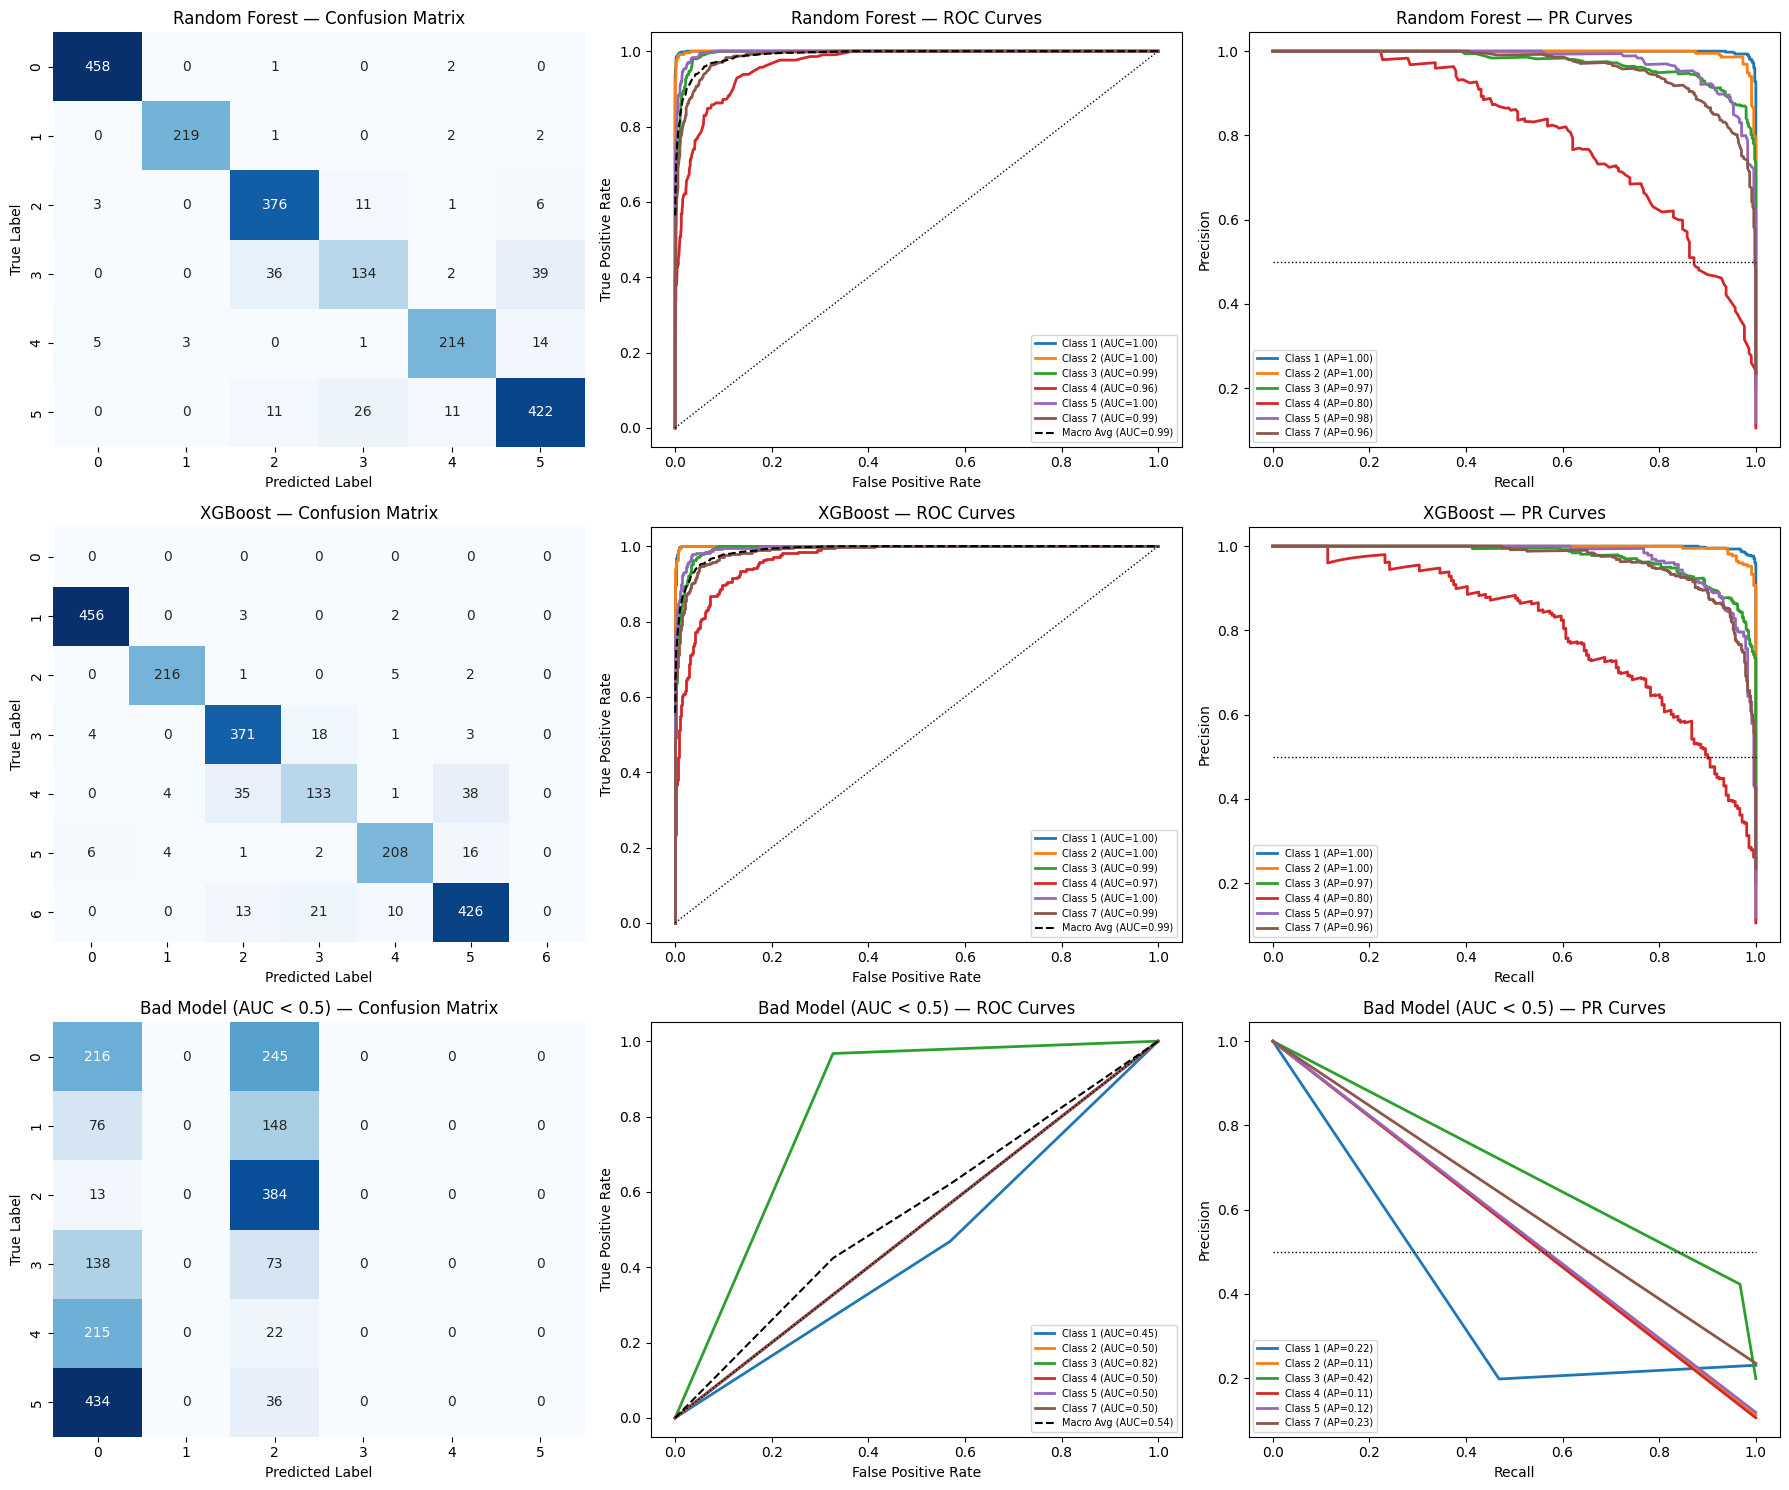

In [29]:
models = [rf, xgb, bad_nn]  # RandomForest, XGBoost, and your BadModel (<0.5 AUC)
titles = ["Random Forest", "XGBoost", "Bad Model (AUC < 0.5)"]

plot_brownie_models(models, X_test_scaled, y_test, classes, titles)
